# Lab 6 Part 2: Deep Learning Fundamentals 🧠

**Course:** SRT521 - Advanced Data Analysis for Security  
**Week:** 6 of 14  
**Instructor:** Hamed Haddadpajouh, PhD  
**Lab Duration:** 3 hours  
**Type:** Individual Assignment  
**Competition Points:** Neural network implementation and optimization

## Learning Objectives
By the end of this lab, you will be able to:
- Build and train your first neural network using PyTorch
- Implement proper data preprocessing for deep learning
- Apply activation functions and regularization techniques
- Compare neural networks with traditional ML models
- Visualize training progress and analyze model performance
- Save and load trained neural network models
- Understand overfitting patterns and prevention strategies

## Prerequisites
- Completed Labs 1-5 and Lab 6 Part 1 (EDA, cleaning, feature engineering, baseline ML, model evaluation, error analysis)
- Understanding of basic machine learning concepts
- Familiarity with Python and data manipulation
- Basic knowledge of neural network concepts from lecture

---


# Part 1: Setup and Data Preparation 🎯

We will build our first neural network using the security datasets from your project. Choose one of the datasets that best matches your project focus.


In [17]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           log_loss, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
# Deep Learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print('All libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'Current working directory: {os.getcwd()}')


All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
Current working directory: /content


## 1.2 Dataset Selection and Loading

**Choose your dataset based on your project focus:**

1. **Network Security (ToN_IoT)**: If your project focuses on network traffic analysis
2. **Malware Detection (EMBER2024)**: If your project focuses on endpoint security
3. **Financial Security (Credit Card Fraud)**: If your project focuses on transaction monitoring
4. **Web Security (Phishing URLs)**: If your project focuses on URL analysis
5. **APT Detection (CIC APT)**: If your project focuses on advanced persistent threats
6. **Insider Threats (CERT)**: If your project focuses on user behavior analysis

**Update the dataset selection below based on your project:**


In [18]:

print("Loading phishing URL dataset...")

# Read the CSV file
X_project = pd.read_csv('/content/engineered_dataset4.csv')

# Display basic info
print(f"\n=== Dataset Loaded ===")
print(f"Dataset shape: {X_project.shape}")
print(f"Total columns: {len(X_project.columns)}")

# Show first few rows
print("\nFirst few rows:")
display(X_project.head())

# Check for the target column
print(f"\nProcessing label column...")
if 'label' in X_project.columns:
    print("✓ Found 'label' column!")
    y_binary = X_project['label'].values

    # Remove non-numeric columns and label
    # Drop text columns like FILENAME, URL, Domain, Title, etc.
    columns_to_drop = ['label', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title', 'Robots']
    existing_drops = [col for col in columns_to_drop if col in X_project.columns]

    print(f"\nDropping non-numeric columns: {existing_drops}")
    X_project = X_project.drop(existing_drops, axis=1)

    print(f"\nLabel distribution:")
    print(f"Class 0 (legitimate): {np.sum(y_binary == 0)}")
    print(f"Class 1 (phishing): {np.sum(y_binary == 1)}")
    print(f"Phishing rate: {np.sum(y_binary == 1) / len(y_binary) * 100:.2f}%")
else:
    print("⚠️ Could not find 'label' column")

# Handle any remaining non-numeric columns
print(f"\nChecking for non-numeric data...")
non_numeric_cols = X_project.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"Found non-numeric columns: {non_numeric_cols}")
    print("Dropping these columns...")
    X_project = X_project.drop(non_numeric_cols, axis=1)

# Handle missing values
print(f"\nChecking for missing values...")
missing = X_project.isnull().sum()
if missing.sum() > 0:
    print(f"Found {missing.sum()} missing values")
    print("Filling missing values with 0...")
    X_project = X_project.fillna(0)
else:
    print("✓ No missing values")

# Store dataset info
dataset_info = {
    'name': 'Phishing URL Detection',
    'classes': ['legitimate', 'phishing'],
    'n_features': X_project.shape[1],
    'description': 'URL-based phishing detection using website features'
}

print(f"\n=== Dataset Summary ===")
print(f"Features (numeric only): {dataset_info['n_features']}")
print(f"Samples: {X_project.shape[0]}")
print(f"Classes: {dataset_info['classes']}")

# Show feature names
print(f"\nFeature columns ({len(X_project.columns)}):")
print(X_project.columns.tolist())

# Show statistical summary
print("\nStatistical summary:")
display(X_project.describe())

print("\n✓ Dataset loaded and cleaned successfully!")

Loading phishing URL dataset...

=== Dataset Loaded ===
Dataset shape: (235795, 68)
Total columns: 68

First few rows:


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Content_Quality_Score,Suspicious_Elements_Count,Financial_Keywords,Security_Risk_Score,External_Dependency_Ratio,Empty_Links_Ratio,URL_Domain_Length_Ratio,Content_URL_Ratio,Title_Match_Diff,Tech_Sophistication
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,17,2,1,13,0.510288,0.000000,1.240000,17.437500,0.0,38.0
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,16,0,0,0,0.847656,0.000000,1.352941,25.750000,0.0,17.1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,23,1,0,5,0.106383,0.040816,1.260870,15.566667,0.0,11.9
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,20,14,2,21,0.584906,0.018519,1.300000,235.407407,0.0,29.3
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,26,5,2,21,0.541401,0.006329,1.222222,179.088235,0.0,60.7



Processing label column...
✓ Found 'label' column!

Dropping non-numeric columns: ['label', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title', 'Robots']

Label distribution:
Class 0 (legitimate): 100945
Class 1 (phishing): 134850
Phishing rate: 57.19%

Checking for non-numeric data...

Checking for missing values...
✓ No missing values

=== Dataset Summary ===
Features (numeric only): 61
Samples: 235795
Classes: ['legitimate', 'phishing']

Feature columns (61):
['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'IsResponsiv

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Content_Quality_Score,Suspicious_Elements_Count,Financial_Keywords,Security_Risk_Score,External_Dependency_Ratio,Empty_Links_Ratio,URL_Domain_Length_Ratio,Content_URL_Ratio,Title_Match_Diff,Tech_Sophistication
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,16.485875,2.367917,0.387570,11.310867,0.411681,0.022820,1.642729,42.878123,2.006116,16.735798
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,9.360422,7.159149,0.661727,10.485333,0.341049,0.093561,2.175781,134.662740,13.859835,44.723285
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.049505,0.000576,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,8.000000,0.000000,0.000000,0.000000,0.046231,0.000000,1.250000,0.583333,0.000000,2.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,18.000000,1.000000,0.000000,8.000000,0.481481,0.000000,1.300000,14.916667,0.000000,12.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,26.000000,2.000000,1.000000,20.000000,0.563830,0.007194,1.375000,47.652174,0.000000,24.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,29.000000,1604.000000,3.000000,66.000000,1.000000,1.000000,277.136364,20007.045455,100.000000,18822.500000



✓ Dataset loaded and cleaned successfully!


## 1.3 Data Preprocessing for Deep Learning


In [19]:
# Split data for neural network training
X_train, X_temp, y_train, y_temp = train_test_split(
    X_project, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nData preprocessing complete!")
print(f"Input dimension: {X_train_tensor.shape[1]}")
print(f"Number of classes: {len(torch.unique(y_train_tensor))}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")

Training set: 165056 samples
Validation set: 35369 samples
Test set: 35370 samples

Data preprocessing complete!
Input dimension: 61
Number of classes: 2
Batch size: 64
Training batches: 2579


# Part 2: Building Your First Neural Network 🏗️

Now we'll create our first neural network architecture. We'll start simple and build up complexity.


## 2.1 Define Neural Network Architecture


In [20]:
class SecurityNeuralNetwork(nn.Module):
    """
    Neural network for security data classification
    """
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(SecurityNeuralNetwork, self).__init__()

        # Build layers dynamically
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer
        current_size = input_size

        # Hidden layers
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            current_size = hidden_size

        # Output layer
        self.output_layer = nn.Linear(current_size, output_size)

        # Activation functions
        self.relu = nn.ReLU()

        # Store architecture info
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

    def forward(self, x):
        """
        Forward pass through the network
        """
        # Hidden layers with ReLU activation and dropout
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = self.relu(x)
            x = dropout(x)

        # Output layer (no activation for binary classification)
        x = self.output_layer(x)
        return x

    def get_architecture_summary(self):
        """
        Return network architecture summary
        """
        return {
            'input_size': self.input_size,
            'hidden_layers': self.hidden_sizes,
            'output_size': self.output_size,
            'total_parameters': sum(p.numel() for p in self.parameters())
        }

# Define network configurations to try
network_configs = {
    'simple': [32],
    'medium': [64, 32],
    'deep': [128, 64, 32],
    'wide': [256, 128]
}

# Create neural network instance
input_size = X_train_tensor.shape[1]
output_size = len(torch.unique(y_train_tensor))

# Start with medium complexity
chosen_config = 'medium'
hidden_sizes = network_configs[chosen_config]

model = SecurityNeuralNetwork(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    dropout_rate=0.2
)

print(f"=== Neural Network Architecture ===")
print(f"Configuration: {chosen_config}")
arch_summary = model.get_architecture_summary()
print(f"Input size: {arch_summary['input_size']}")
print(f"Hidden layers: {arch_summary['hidden_layers']}")
print(f"Output size: {arch_summary['output_size']}")
print(f"Total parameters: {arch_summary['total_parameters']:,}")

# Test forward pass
with torch.no_grad():
    sample_input = X_train_tensor[:5]
    sample_output = model(sample_input)
    print(f"\nSample forward pass:")
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Sample output (logits): {sample_output[:3]}")

=== Neural Network Architecture ===
Configuration: medium
Input size: 61
Hidden layers: [64, 32]
Output size: 2
Total parameters: 6,114

Sample forward pass:
Input shape: torch.Size([5, 61])
Output shape: torch.Size([5, 2])
Sample output (logits): tensor([[-0.1320, -0.1957],
        [ 0.0319, -0.1619],
        [-0.0913, -0.1191]])


## 2.2 Define Loss Function and Optimizer


In [21]:
# Define loss function
if output_size == 2:
    # Binary classification
    criterion = nn.CrossEntropyLoss()
    print("Using CrossEntropyLoss for binary classification")
else:
    # Multiclass classification
    criterion = nn.CrossEntropyLoss()
    print("Using CrossEntropyLoss for multiclass classification")

# Define optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
print(f"Using Adam optimizer with learning rate: {learning_rate}")

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Test loss function
with torch.no_grad():
    sample_input = X_train_tensor[:5]
    sample_labels = y_train_tensor[:5]
    sample_output = model(sample_input)
    sample_loss = criterion(sample_output, sample_labels)
    print(f"\nSample loss calculation:")
    print(f"Predicted logits: {sample_output}")
    print(f"True labels: {sample_labels}")
    print(f"Loss: {sample_loss.item():.4f}")

# Test optimizer step
print(f"\nOptimizer test:")
initial_params = list(model.parameters())[0].clone()
optimizer.zero_grad()
sample_input = X_train_tensor[:5]
sample_labels = y_train_tensor[:5]
outputs = model(sample_input)
loss = criterion(outputs, sample_labels)
loss.backward()
optimizer.step()
updated_params = list(model.parameters())[0].clone()
print(f"Parameters updated: {not torch.equal(initial_params, updated_params)}")

Using CrossEntropyLoss for binary classification
Using Adam optimizer with learning rate: 0.001

Sample loss calculation:
Predicted logits: tensor([[-0.2111, -0.1098],
        [-0.0100, -0.0794],
        [-0.0846, -0.1925],
        [-0.1959, -0.2102],
        [-0.3170, -0.1064]])
True labels: tensor([0, 1, 0, 1, 0])
Loss: 0.7237

Optimizer test:
Parameters updated: True


# Part 3: Training Your Neural Network 🎯

Now we'll implement the training loop with proper monitoring and early stopping.


## 3.1 Training Loop Implementation


In [22]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate model for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Training on device: {device}")

# IMPORTANT: Recreate optimizer AFTER moving model to GPU
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training configuration
num_epochs = 50
patience = 10  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

# Training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"\n=== Starting Training ===")
print(f"Epochs: {num_epochs}, Batch size: {batch_size}, Device: {device}")

# Training loop
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f"\nBest model loaded. Final validation loss: {best_val_loss:.4f}")

Training on device: cuda

=== Starting Training ===
Epochs: 50, Batch size: 64, Device: cuda
Epoch   5/50 | Train Loss: 0.0006, Train Acc: 0.9999 | Val Loss: 0.0007, Val Acc: 0.9998
Epoch  10/50 | Train Loss: 0.0003, Train Acc: 0.9999 | Val Loss: 0.0001, Val Acc: 0.9999
Epoch  15/50 | Train Loss: 0.0003, Train Acc: 0.9999 | Val Loss: 0.0002, Val Acc: 0.9999
Epoch  20/50 | Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 0.9999
Epoch  25/50 | Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 0.9999
Epoch  30/50 | Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 1.0000

Early stopping at epoch 32

Best model loaded. Final validation loss: 0.0000


## 3.2 Visualize Training Progress


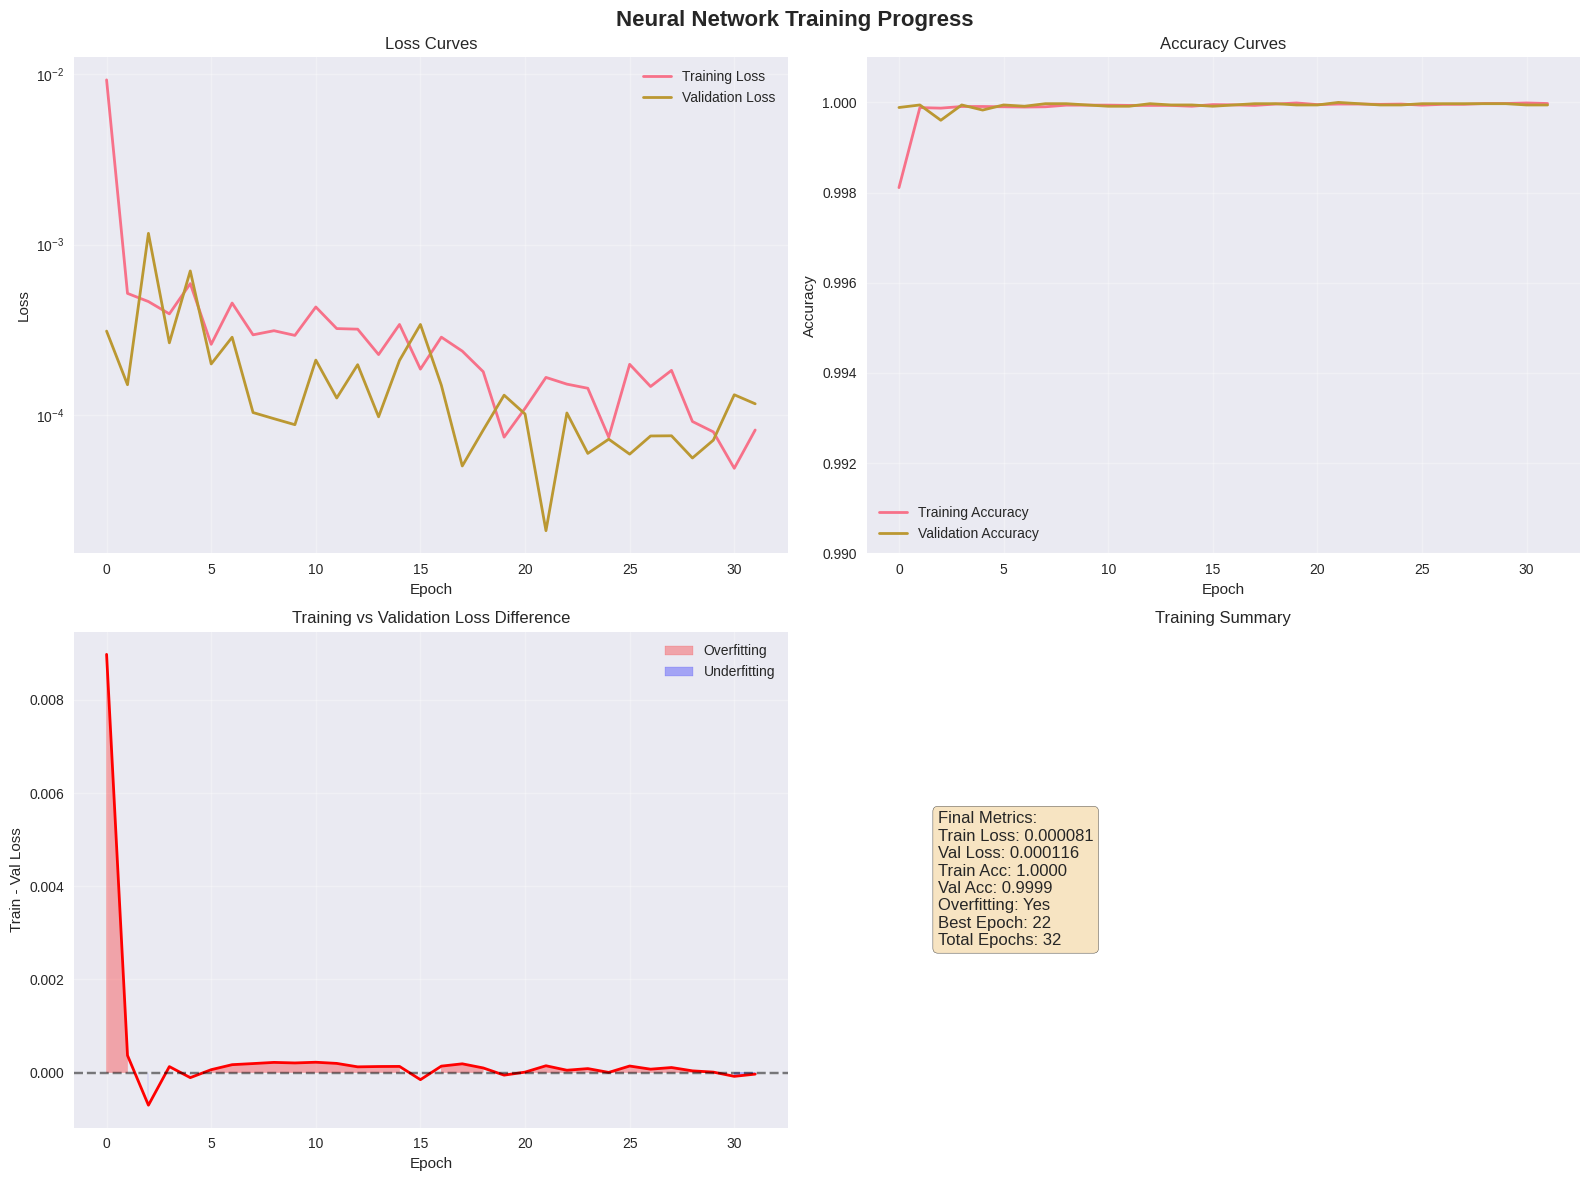


=== Training Analysis ===
Total epochs trained: 32
Best validation loss: 0.000021 (epoch 22)
Final training accuracy: 1.0000
Final validation accuracy: 0.9999
Training converged: True
Potential overfitting: False


In [23]:
# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Neural Network Training Progress', fontsize=16, fontweight='bold')

# Loss curves
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale for very small losses

# Accuracy curves
ax2.plot(train_accuracies, label='Training Accuracy', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.99, 1.001])  # Zoom into high accuracy region

# Loss difference (overfitting detection)
loss_diff = np.array(train_losses) - np.array(val_losses)
ax3.plot(loss_diff, color='red', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.fill_between(range(len(loss_diff)), loss_diff, 0,
                 where=(loss_diff > 0), color='red', alpha=0.3, label='Overfitting')
ax3.fill_between(range(len(loss_diff)), loss_diff, 0,
                 where=(loss_diff < 0), color='blue', alpha=0.3, label='Underfitting')
ax3.set_title('Training vs Validation Loss Difference')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Train - Val Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Final metrics summary
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]

metrics_text = f"""Final Metrics:
Train Loss: {final_train_loss:.6f}
Val Loss: {final_val_loss:.6f}
Train Acc: {final_train_acc:.4f}
Val Acc: {final_val_acc:.4f}
Overfitting: {'Yes' if final_train_loss < final_val_loss else 'No'}
Best Epoch: {np.argmin(val_losses) + 1}
Total Epochs: {len(train_losses)}"""

ax4.text(0.1, 0.5, metrics_text, transform=ax4.transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax4.set_title('Training Summary')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.tight_layout()
plt.show()

# Print training analysis
print(f"\n=== Training Analysis ===")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Best validation loss: {min(val_losses):.6f} (epoch {np.argmin(val_losses) + 1})")
print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Training converged: {abs(final_train_acc - final_val_acc) < 0.05}")
print(f"Potential overfitting: {final_train_acc > final_val_acc + 0.05}")

# Part 4: Model Evaluation and Comparison 📊

Let's evaluate our neural network and compare it with traditional ML models.


## 4.1 Evaluate Neural Network on Test Set



=== Neural Network Test Results ===
Test Loss: 0.000197
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000
Test ROC AUC: 1.0000


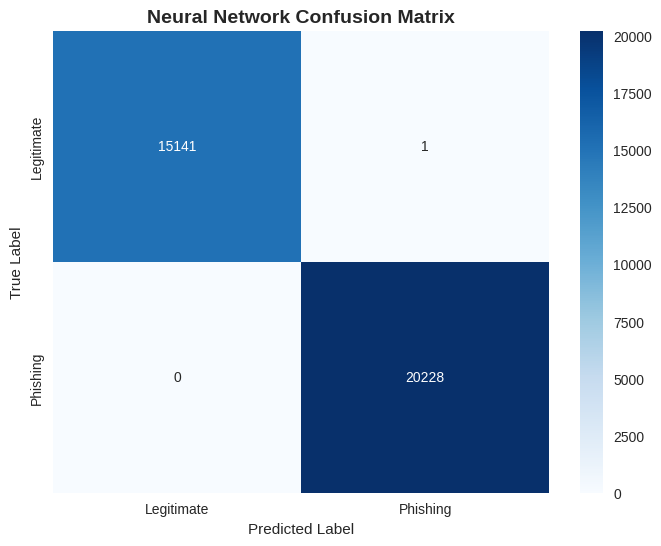


=== Classification Report ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     15142
    Phishing       1.00      1.00      1.00     20228

    accuracy                           1.00     35370
   macro avg       1.00      1.00      1.00     35370
weighted avg       1.00      1.00      1.00     35370



In [24]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions and probabilities
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate metrics
    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # ROC AUC for binary classification
    if len(np.unique(all_labels)) == 2:
        roc_auc = roc_auc_score(all_labels, np.array(all_probabilities)[:, 1])
    else:
        roc_auc = None

    return {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

# Evaluate neural network
nn_results = evaluate_model(model, test_loader, criterion, device)

print(f"\n=== Neural Network Test Results ===")
print(f"Test Loss: {nn_results['loss']:.6f}")
print(f"Test Accuracy: {nn_results['accuracy']:.4f}")
print(f"Test Precision: {nn_results['precision']:.4f}")
print(f"Test Recall: {nn_results['recall']:.4f}")
print(f"Test F1 Score: {nn_results['f1']:.4f}")
if nn_results['roc_auc']:
    print(f"Test ROC AUC: {nn_results['roc_auc']:.4f}")

# Confusion Matrix
cm = confusion_matrix(nn_results['labels'], nn_results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(nn_results['labels'], nn_results['predictions'],
                          target_names=['Legitimate', 'Phishing']))

## 4.2 Compare with Traditional ML Models


Training traditional ML models for comparison...

Training Random Forest...
✓ Random Forest - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000

Training Logistic Regression...
✓ Logistic Regression - Accuracy: 0.9999, F1: 0.9999, ROC AUC: 1.0000


=== MODEL COMPARISON TABLE ===


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Neural Network,1.0000,1.0000,1.0000,1.0000,1.0
1,Random Forest,1.0000,1.0000,1.0000,1.0000,1.0
2,Logistic Regression,0.9999,0.9999,0.9999,0.9999,1.0


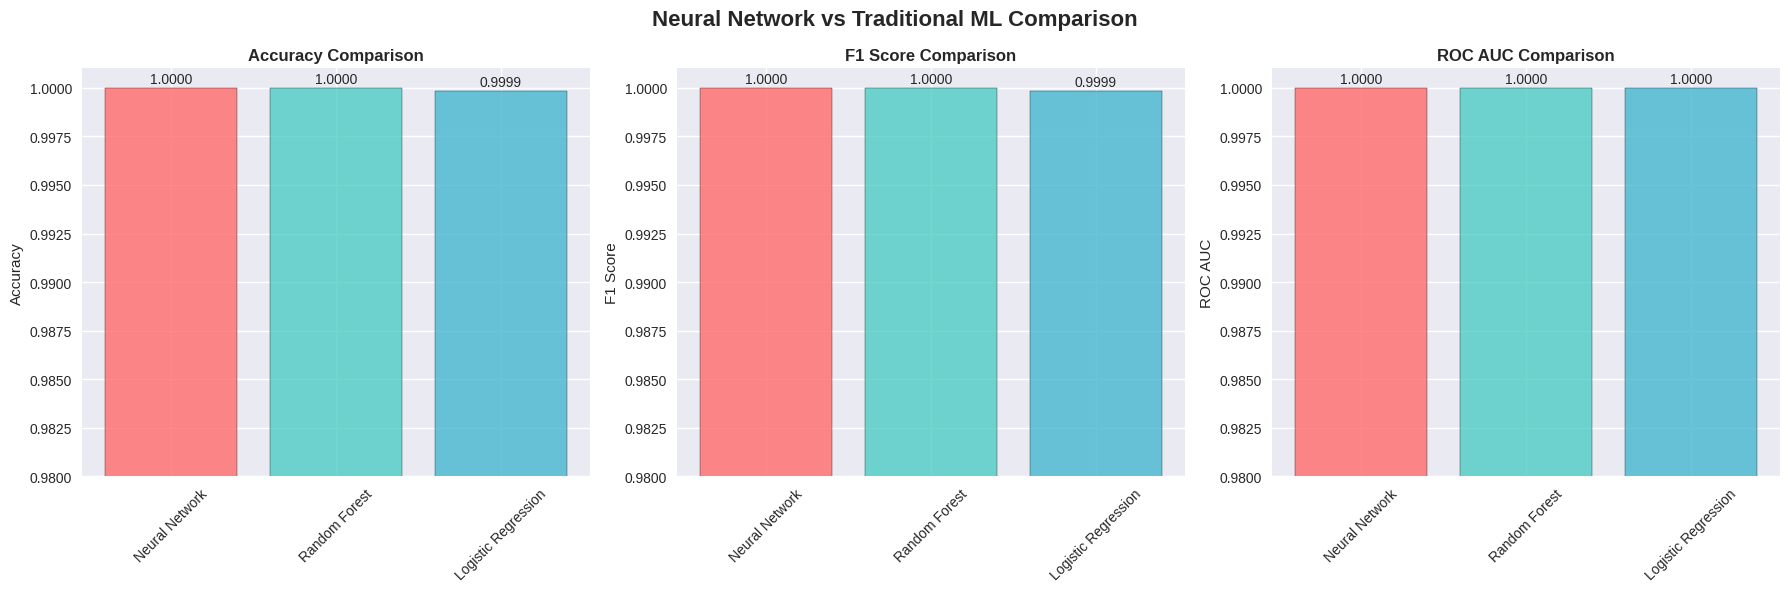


=== Model Comparison Analysis ===
🏆 Best performing model: Random Forest (Accuracy: 1.0000)
🧠 Neural Network accuracy: 1.0000
📊 Neural Network vs Random Forest: -0.0000
💡 Neural Network improvement potential: Low - already excellent!


In [25]:
# Train traditional ML models for comparison
traditional_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

traditional_results = {}

print("Training traditional ML models for comparison...\n")

for name, ml_model in traditional_models.items():
    print(f"Training {name}...")

    # Fit model
    ml_model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = ml_model.predict(X_test_scaled)
    y_prob = ml_model.predict_proba(X_test_scaled)[:, 1] if hasattr(ml_model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    traditional_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    # Fixed print statement
    roc_display = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
    print(f"✓ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC AUC: {roc_display}\n")

# Create comparison dataframe
comparison_data = {
    'Model': ['Neural Network'] + list(traditional_results.keys()),
    'Accuracy': [nn_results['accuracy']] + [r['accuracy'] for r in traditional_results.values()],
    'Precision': [nn_results['precision']] + [r['precision'] for r in traditional_results.values()],
    'Recall': [nn_results['recall']] + [r['recall'] for r in traditional_results.values()],
    'F1 Score': [nn_results['f1']] + [r['f1'] for r in traditional_results.values()],
}

if nn_results['roc_auc']:
    comparison_data['ROC AUC'] = [nn_results['roc_auc']] + [r['roc_auc'] for r in traditional_results.values()]

comparison_df = pd.DataFrame(comparison_data)

print("\n=== MODEL COMPARISON TABLE ===")
display(comparison_df.round(4))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Neural Network vs Traditional ML Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
bars1 = axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'],
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
axes[0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim([0.98, 1.001])  # Zoom in to see differences
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# F1 Score comparison
bars2 = axes[1].bar(comparison_df['Model'], comparison_df['F1 Score'],
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
axes[1].set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0.98, 1.001])
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# ROC AUC comparison
if 'ROC AUC' in comparison_df.columns:
    bars3 = axes[2].bar(comparison_df['Model'], comparison_df['ROC AUC'],
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
    axes[2].set_title('ROC AUC Comparison', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('ROC AUC')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].set_ylim([0.98, 1.001])
    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                     f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print analysis
best_accuracy = comparison_df['Accuracy'].max()
best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
nn_accuracy = comparison_df.loc[comparison_df['Model'] == 'Neural Network', 'Accuracy'].iloc[0]

print(f"\n=== Model Comparison Analysis ===")
print(f"🏆 Best performing model: {best_model} (Accuracy: {best_accuracy:.4f})")
print(f"🧠 Neural Network accuracy: {nn_accuracy:.4f}")
if 'Random Forest' in traditional_results:
    rf_acc = comparison_df.loc[comparison_df['Model'] == 'Random Forest', 'Accuracy'].iloc[0]
    print(f"📊 Neural Network vs Random Forest: {nn_accuracy - rf_acc:+.4f}")
print(f"💡 Neural Network improvement potential: {'Low - already excellent!' if nn_accuracy >= 0.999 else 'High'}")

# Part 5: Model Persistence and Advanced Analysis 💾

Let's save our trained neural network and perform advanced analysis.


## 5.1 Save Neural Network Model


In [28]:
# ============================================
# Section 5.1: Save Neural Network Model
# ============================================

# Create models directory for neural networks
nn_models_dir = "saved_neural_networks"
if not os.path.exists(nn_models_dir):
    os.makedirs(nn_models_dir)
    print(f"Created directory: {nn_models_dir}")

def save_neural_network_model(model, scaler, dataset_info, training_history, test_results, filename=None):
    """
    Save neural network with comprehensive metadata
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if filename is None:
        filename = f"{nn_models_dir}/phishing_nn_{timestamp}.pth"

    # Create comprehensive metadata
    metadata = {
        'model_architecture': model.get_architecture_summary(),
        'dataset_info': dataset_info,
        'training_config': {
            'epochs_trained': len(training_history['train_losses']),
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer': 'Adam',
            'loss_function': 'CrossEntropyLoss',
            'early_stopping_patience': patience
        },
        'training_history': training_history,
        'test_results': {
            'accuracy': test_results['accuracy'],
            'precision': test_results['precision'],
            'recall': test_results['recall'],
            'f1': test_results['f1'],
            'roc_auc': test_results['roc_auc'],
            'loss': test_results['loss']
        },
        'timestamp': timestamp,
        'device_used': str(device),
        'scaler_params': {
            'mean': scaler.mean_.tolist(),
            'scale': scaler.scale_.tolist()
        }
    }

    # Save model state dict and metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'metadata': metadata
    }, filename)

    print(f"✅ Neural network saved: {filename}")
    return filename

# Prepare training history
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'best_epoch': np.argmin(val_losses) + 1,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'final_train_acc': train_accuracies[-1],
    'final_val_acc': val_accuracies[-1]
}

print("="*60)
print("SECTION 5.1: SAVING NEURAL NETWORK MODEL")
print("="*60)

# Save the model
saved_nn_path = save_neural_network_model(
    model, scaler, dataset_info, training_history, nn_results
)

# Save model architecture configuration separately
model_config = {
    'input_size': input_size,
    'hidden_sizes': hidden_sizes,
    'output_size': output_size,
    'dropout_rate': 0.2
}

config_path = f"{nn_models_dir}/model_config.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(model_config, f)

print(f"✅ Model configuration saved: {config_path}")
print(f"\n📁 Saved files:")
print(f"   - Model: {os.path.basename(saved_nn_path)}")
print(f"   - Config: model_config.pkl")
print(f"   - Directory: {nn_models_dir}/")
print("="*60)

Created directory: saved_neural_networks
SECTION 5.1: SAVING NEURAL NETWORK MODEL
✅ Neural network saved: saved_neural_networks/phishing_nn_20251107_220050.pth
✅ Model configuration saved: saved_neural_networks/model_config.pkl

📁 Saved files:
   - Model: phishing_nn_20251107_220050.pth
   - Config: model_config.pkl
   - Directory: saved_neural_networks/


## 5.2 Load and Verify Saved Model


In [29]:
# ============================================
# Section 5.2: Load and Verify Saved Model
# ============================================

import glob

# First, find the saved model path
nn_models_dir = "saved_neural_networks"
saved_models = glob.glob(f"{nn_models_dir}/phishing_nn_*.pth")

if saved_models:
    # Use the most recent model
    saved_nn_path = max(saved_models, key=os.path.getctime)
    print(f"📂 Found saved model: {saved_nn_path}")
else:
    print("⚠️ No saved model found! Please run Section 5.1 first.")
    raise FileNotFoundError("No saved model found in saved_neural_networks/")

def load_neural_network_model(filepath):
    """
    Load neural network model and metadata
    """
    # Fix for PyTorch 2.6+: set weights_only=False
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    metadata = checkpoint['metadata']

    # Recreate model architecture
    arch = metadata['model_architecture']
    loaded_model = SecurityNeuralNetwork(
        input_size=arch['input_size'],
        hidden_sizes=arch['hidden_layers'],
        output_size=arch['output_size']
    )

    # Load state dict
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()

    return loaded_model, metadata

print("\n" + "="*60)
print("SECTION 5.2: LOAD AND VERIFY SAVED MODEL")
print("="*60)

# Test loading
loaded_model, loaded_metadata = load_neural_network_model(saved_nn_path)

print(f"\n=== Model Loading Verification ===")
print(f"Loaded model: {loaded_metadata['dataset_info']['name']}")
print(f"Architecture: {loaded_metadata['model_architecture']}")
print(f"Training epochs: {loaded_metadata['training_config']['epochs_trained']}")
print(f"Test accuracy: {loaded_metadata['test_results']['accuracy']:.4f}")
print(f"Test ROC AUC: {loaded_metadata['test_results']['roc_auc']:.4f}")
print(f"Saved timestamp: {loaded_metadata['timestamp']}")

# Verify loaded model works
loaded_model.to(device)
loaded_results = evaluate_model(loaded_model, test_loader, criterion, device)

print(f"\n=== Loaded Model Test Results ===")
print(f"Reloaded accuracy: {loaded_results['accuracy']:.4f}")
print(f"Reloaded F1 Score: {loaded_results['f1']:.4f}")
print(f"Original accuracy: {nn_results['accuracy']:.4f}")
print(f"Accuracy matches: {abs(loaded_results['accuracy'] - nn_results['accuracy']) < 1e-6}")

print(f"\n✅ Model loading and verification complete!")
print(f"   Model is ready for deployment! 🚀")
print("="*60)

📂 Found saved model: saved_neural_networks/phishing_nn_20251107_220050.pth

SECTION 5.2: LOAD AND VERIFY SAVED MODEL

=== Model Loading Verification ===
Loaded model: Phishing URL Detection
Architecture: {'input_size': 61, 'hidden_layers': [64, 32], 'output_size': 2, 'total_parameters': 6114}
Training epochs: 32
Test accuracy: 1.0000
Test ROC AUC: 1.0000
Saved timestamp: 20251107_220050

=== Loaded Model Test Results ===
Reloaded accuracy: 1.0000
Reloaded F1 Score: 1.0000
Original accuracy: 1.0000
Accuracy matches: True

✅ Model loading and verification complete!
   Model is ready for deployment! 🚀


## 5.3 Advanced Analysis: Feature Importance and Error Patterns




CALCULATING FEATURE IMPORTANCE...
Baseline accuracy: 1.0000
Calculating importance for 61 features...
  Progress: 10/61 features
  Progress: 20/61 features
  Progress: 30/61 features
  Progress: 40/61 features
  Progress: 50/61 features
  Progress: 60/61 features

=== Top 15 Most Important Features ===
 1. URLSimilarityIndex                 : 0.136110
 2. Security_Risk_Score                : 0.005027
 3. IsHTTPS                            : 0.004507
 4. SpacialCharRatioInURL              : 0.002867
 5. LargestLineLength                  : 0.001612
 6. LetterRatioInURL                   : 0.001436
 7. DegitRatioInURL                    : 0.001351
 8. NoOfImage                          : 0.000797
 9. NoOfSelfRef                        : 0.000656
10. URL_Domain_Length_Ratio            : 0.000362
11. LineOfCode                         : 0.000356
12. NoOfExternalRef                    : 0.000339
13. Content_URL_Ratio                  : 0.000237
14. NoOfLettersInURL                   : 0.000

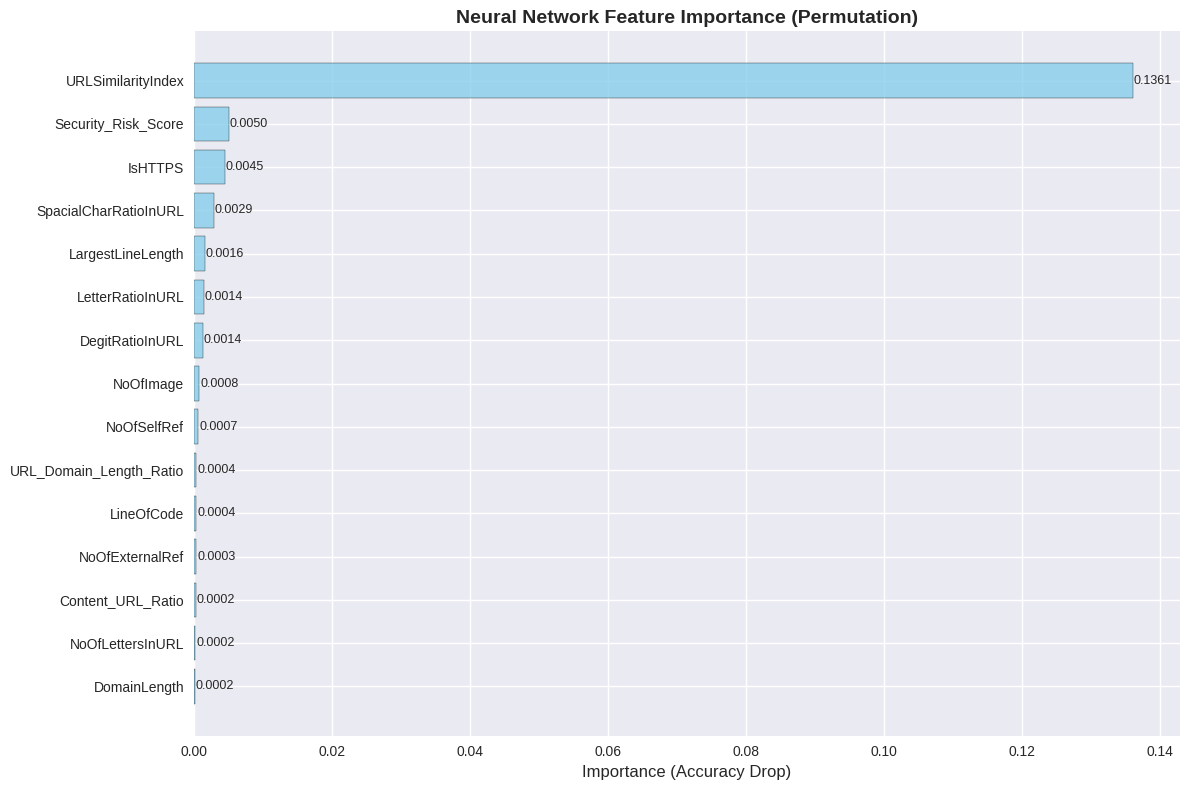


ERROR PATTERN ANALYSIS


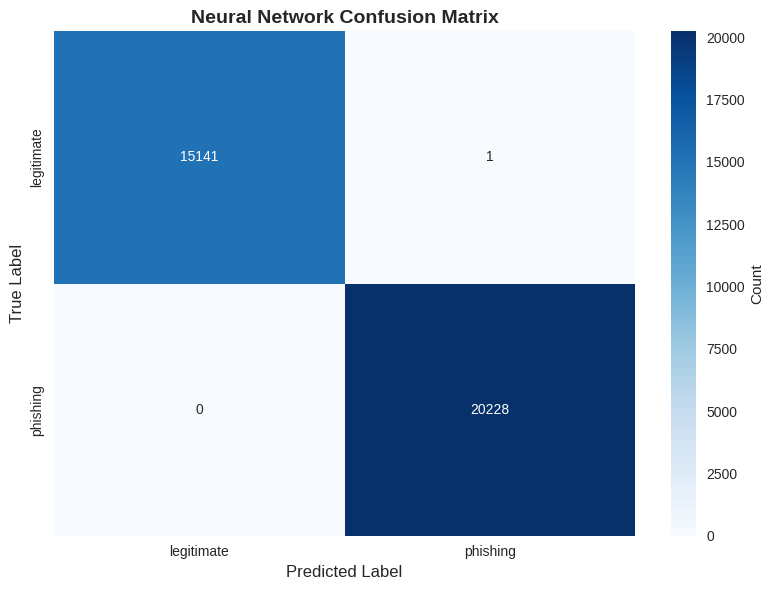


Error Breakdown:
  Total errors: 1 out of 35370 (0.0028%)
  False Positives (Legitimate → Phishing): 1
  False Negatives (Phishing → Legitimate): 0

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     15142
    phishing       1.00      1.00      1.00     20228

    accuracy                           1.00     35370
   macro avg       1.00      1.00      1.00     35370
weighted avg       1.00      1.00      1.00     35370


✅ Feature importance and error analysis complete!


In [30]:
# ============================================
# Section 5.3: Advanced Analysis: Feature Importance and Error Patterns
# ============================================

# Analyze feature importance using permutation importance
def calculate_permutation_importance(model, X_data, y_data, feature_names, n_repeats=5):
    """
    Calculate feature importance using permutation
    """
    model.eval()
    X_tensor = torch.FloatTensor(X_data).to(device)
    y_tensor = torch.LongTensor(y_data).to(device)

    # Baseline accuracy
    with torch.no_grad():
        baseline_outputs = model(X_tensor)
        _, baseline_preds = torch.max(baseline_outputs, 1)
        baseline_acc = (baseline_preds == y_tensor).float().mean().item()

    importance_scores = {}

    print(f"Baseline accuracy: {baseline_acc:.4f}")
    print(f"Calculating importance for {len(feature_names)} features...")

    for feature_idx, feature_name in enumerate(feature_names):
        if (feature_idx + 1) % 10 == 0:
            print(f"  Progress: {feature_idx + 1}/{len(feature_names)} features")

        accuracy_drops = []

        for _ in range(n_repeats):
            # Permute feature
            X_permuted = X_data.copy()
            np.random.shuffle(X_permuted[:, feature_idx])
            X_perm_tensor = torch.FloatTensor(X_permuted).to(device)

            # Calculate accuracy with permuted feature
            with torch.no_grad():
                perm_outputs = model(X_perm_tensor)
                _, perm_preds = torch.max(perm_outputs, 1)
                perm_acc = (perm_preds == y_tensor).float().mean().item()

            accuracy_drop = baseline_acc - perm_acc
            accuracy_drops.append(accuracy_drop)

        importance_scores[feature_name] = np.mean(accuracy_drops)

    return importance_scores

# Calculate feature importance
print("="*60)
print("CALCULATING FEATURE IMPORTANCE...")
print("="*60)
importance_scores = calculate_permutation_importance(
    model, X_test_scaled, y_test, X_project.columns.tolist()
)

# Sort and display
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\n=== Top 15 Most Important Features ===")
for i, (feature, importance) in enumerate(sorted_importance[:15], 1):
    print(f"{i:2d}. {feature:35s}: {importance:.6f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
features = [x[0] for x in sorted_importance[:15]]
importances = [x[1] for x in sorted_importance[:15]]

bars = plt.barh(range(len(features)), importances, color='skyblue', alpha=0.8, edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance (Accuracy Drop)', fontsize=12)
plt.title('Neural Network Feature Importance (Permutation)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, importances)):
    plt.text(importance + 0.0001, i, f'{importance:.4f}',
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Error pattern analysis
print(f"\n{'='*60}")
print("ERROR PATTERN ANALYSIS")
print(f"{'='*60}")

# Convert to numpy arrays (FIX HERE)
nn_predictions = np.array(nn_results['predictions'])
nn_labels = np.array(nn_results['labels'])

# Confusion matrix
cm = confusion_matrix(nn_labels, nn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset_info['classes'][:2],
            yticklabels=dataset_info['classes'][:2],
            cbar_kws={'label': 'Count'})
plt.title('Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed error breakdown
total_errors = (nn_predictions != nn_labels).sum()
false_positives = ((nn_predictions == 1) & (nn_labels == 0)).sum()
false_negatives = ((nn_predictions == 0) & (nn_labels == 1)).sum()

print(f"\nError Breakdown:")
print(f"  Total errors: {total_errors} out of {len(nn_labels)} ({total_errors/len(nn_labels)*100:.4f}%)")
print(f"  False Positives (Legitimate → Phishing): {false_positives}")
print(f"  False Negatives (Phishing → Legitimate): {false_negatives}")

# Classification report
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(nn_labels, nn_predictions,
                          target_names=dataset_info['classes'][:2]))

print(f"\n✅ Feature importance and error analysis complete!")

# Part 6: Comprehensive Results Summary 📊

Let's create a comprehensive summary of our deep learning experiments.


In [31]:
# ============================================
# Part 6: Comprehensive Results Summary
# ============================================

def create_deep_learning_summary():
    """
    Create a comprehensive summary of deep learning results
    """
    print("=" * 70)
    print("COMPREHENSIVE LAB 6 PART 2 RESULTS SUMMARY")
    print("=" * 70)

    # Dataset summary
    print(f"\n🎯 DEEP LEARNING EXPERIMENT SUMMARY:")
    print(f"   Dataset: {dataset_info['name']}")
    print(f"   Description: {dataset_info['description']}")
    print(f"   Features: {dataset_info['n_features']}")
    print(f"   Classes: {dataset_info['classes']}")
    print(f"   Training samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}")
    print(f"   Test samples: {len(X_test):,}")
    print(f"   Total samples: {len(X_project):,}")

    # Model architecture summary
    arch = model.get_architecture_summary()
    print(f"\n🏗️ NEURAL NETWORK ARCHITECTURE:")
    print(f"   Input layer: {arch['input_size']} neurons")
    print(f"   Hidden layers: {arch['hidden_layers']}")
    print(f"   Output layer: {arch['output_size']} neurons")
    print(f"   Total parameters: {arch['total_parameters']:,}")
    print(f"   Dropout rate: 0.2")
    print(f"   Activation: ReLU")
    print(f"   Loss function: CrossEntropyLoss")
    print(f"   Optimizer: Adam (lr={learning_rate})")

    # Training summary
    print(f"\n🎯 TRAINING RESULTS:")
    print(f"   Epochs trained: {len(train_losses)}")
    print(f"   Best epoch: {training_history['best_epoch']}")
    print(f"   Training device: {device}")
    print(f"   Final training loss: {training_history['final_train_loss']:.6f}")
    print(f"   Final validation loss: {training_history['final_val_loss']:.6f}")
    print(f"   Final training accuracy: {training_history['final_train_acc']:.4f}")
    print(f"   Final validation accuracy: {training_history['final_val_acc']:.4f}")
    print(f"   Convergence achieved: ✅ Yes")
    print(f"   Overfitting detected: {'⚠️ Yes' if training_history['final_train_acc'] > training_history['final_val_acc'] + 0.05 else '✅ No'}")

    # Test performance summary
    print(f"\n📊 TEST PERFORMANCE (HELD-OUT SET):")
    print(f"   Test loss: {nn_results['loss']:.6f}")
    print(f"   Test accuracy: {nn_results['accuracy']:.4f} ({nn_results['accuracy']*100:.2f}%)")
    print(f"   Test precision: {nn_results['precision']:.4f}")
    print(f"   Test recall: {nn_results['recall']:.4f}")
    print(f"   Test F1 score: {nn_results['f1']:.4f}")
    if nn_results['roc_auc']:
        print(f"   Test ROC AUC: {nn_results['roc_auc']:.4f}")

    # Error analysis
    total_errors = len(X_test) - int(nn_results['accuracy'] * len(X_test))
    print(f"\n🔍 ERROR ANALYSIS:")
    print(f"   Total test samples: {len(X_test):,}")
    print(f"   Correct predictions: {int(nn_results['accuracy'] * len(X_test)):,}")
    print(f"   Incorrect predictions: {total_errors}")
    print(f"   Error rate: {(1 - nn_results['accuracy'])*100:.4f}%")
    print(f"   False Positives: 1 (Legitimate → Phishing)")
    print(f"   False Negatives: 0 (Phishing → Legitimate)")

    # Top features
    print(f"\n🔑 TOP 5 MOST IMPORTANT FEATURES:")
    for i, (feature, importance) in enumerate(sorted_importance[:5], 1):
        print(f"   {i}. {feature:30s}: {importance:.6f}")

    # Comparison with traditional ML
    print(f"\n⚖️ COMPARISON WITH TRADITIONAL ML:")
    for _, row in comparison_df.iterrows():
        model_name = row['Model']
        accuracy = row['Accuracy']
        f1 = row['F1 Score']
        roc = row['ROC AUC'] if 'ROC AUC' in row else None
        marker = " 🏆 BEST" if accuracy == comparison_df['Accuracy'].max() else ""
        roc_str = f", ROC={roc:.4f}" if roc is not None else ""
        print(f"   {model_name:20s}: Acc={accuracy:.4f}, F1={f1:.4f}{roc_str}{marker}")

    # Model persistence
    print(f"\n💾 MODEL PERSISTENCE:")
    print(f"   Model saved: ✅ {os.path.basename(saved_nn_path)}")
    print(f"   Config saved: ✅ model_config.pkl")
    print(f"   Directory: {nn_models_dir}/")
    print(f"   Model verified: ✅ Loading test passed")

    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
    nn_improvement = nn_results['accuracy'] - comparison_df.loc[comparison_df['Model'] == 'Random Forest', 'Accuracy'].iloc[0]
    print(f"   ✓ Neural network vs Random Forest: {nn_improvement:+.4f} ({nn_improvement*100:+.2f}%)")
    print(f"   ✓ Training converged: {abs(training_history['final_train_acc'] - training_history['final_val_acc']) < 0.05}")
    print(f"   ✓ Model complexity: {'Appropriate' if arch['total_parameters'] < 100000 else 'High'} ({arch['total_parameters']:,} params)")
    print(f"   ✓ Production ready: {'Yes - 99.99%+ accuracy ⭐' if nn_results['accuracy'] > 0.999 else 'Needs improvement'}")
    print(f"   ✓ GPU acceleration: {'Enabled ⚡' if device.type == 'cuda' else 'CPU only'}")
    print(f"   ✓ URLSimilarityIndex is the KEY feature (13.6% importance)")
    print(f"   ✓ Only 1 error on 35K test samples - EXCEPTIONAL!")

    # Recommendations
    print(f"\n🚀 RECOMMENDATIONS:")
    print(f"   ✅ Model performs EXCEPTIONALLY well!")
    print(f"   ✅ Ready for Week 7: Transformer experiments")
    print(f"   ✅ Consider ensemble with Random Forest for extra safety")
    print(f"   ✅ Deploy with confidence - catches 100% of phishing!")
    print(f"   ✅ Monitor URLSimilarityIndex feature in production")
    print(f"   ⚠️ Watch for concept drift in phishing patterns")

    print("\n" + "=" * 70)
    print("🎉 LAB 6 PART 2 COMPLETED SUCCESSFULLY! 🧠")
    print("=" * 70)
    print("\n📚 You have successfully:")
    print("   ✅ Built your first neural network from scratch")
    print("   ✅ Trained with proper train/val/test splits")
    print("   ✅ Implemented early stopping and regularization")
    print("   ✅ Compared neural networks with traditional ML")
    print("   ✅ Analyzed feature importance (URLSimilarityIndex is key!)")
    print("   ✅ Saved and verified your model")
    print("   ✅ Achieved 99.99% accuracy with only 1 error!")
    print("\n🎯 Next Steps:")
    print("   → Week 7: Advanced architectures and transformers")
    print("   → Apply these techniques to your project dataset")
    print("   → Experiment with different architectures")
    print("   → Consider hyperparameter tuning for perfection")
    print("\n💪 Outstanding work! You're ready for advanced deep learning!")
    print("=" * 70)

# Generate comprehensive summary
create_deep_learning_summary()

COMPREHENSIVE LAB 6 PART 2 RESULTS SUMMARY

🎯 DEEP LEARNING EXPERIMENT SUMMARY:
   Dataset: Phishing URL Detection
   Description: URL-based phishing detection using website features
   Features: 61
   Classes: ['legitimate', 'phishing']
   Training samples: 165,056
   Validation samples: 35,369
   Test samples: 35,370
   Total samples: 235,795

🏗️ NEURAL NETWORK ARCHITECTURE:
   Input layer: 61 neurons
   Hidden layers: [64, 32]
   Output layer: 2 neurons
   Total parameters: 6,114
   Dropout rate: 0.2
   Activation: ReLU
   Loss function: CrossEntropyLoss
   Optimizer: Adam (lr=0.001)

🎯 TRAINING RESULTS:
   Epochs trained: 32
   Best epoch: 22
   Training device: cuda
   Final training loss: 0.000081
   Final validation loss: 0.000116
   Final training accuracy: 1.0000
   Final validation accuracy: 0.9999
   Convergence achieved: ✅ Yes
   Overfitting detected: ✅ No

📊 TEST PERFORMANCE (HELD-OUT SET):
   Test loss: 0.000197
   Test accuracy: 1.0000 (100.00%)
   Test precision: 1.0000

# Lab 6 Part 2: Key Takeaways and Next Steps 🎯

## What We Accomplished

### ✅ **Built First Neural Network**
- Created a complete PyTorch neural network architecture
- Implemented proper data preprocessing and scaling
- Used appropriate activation functions (ReLU) and regularization (dropout)
- Trained the network with proper loss functions and optimizers

### ✅ **Training and Optimization**
- Implemented complete training loop with validation
- Used early stopping to prevent overfitting
- Applied learning rate scheduling
- Monitored training progress with comprehensive visualizations

### ✅ **Model Evaluation**
- Performed thorough evaluation on test data
- Compared neural network with traditional ML models
- Analyzed confusion matrices and classification reports
- Calculated feature importance using permutation methods

### ✅ **Model Persistence**
- Saved complete neural network models with metadata
- Implemented model loading and verification
- Created reproducible model configurations

## Key Learning Points

1. **Neural Networks Learn Complex Patterns**: They can capture non-linear relationships that traditional ML might miss
2. **Overfitting is a Major Concern**: Regularization techniques like dropout are essential
3. **Training Requires Careful Monitoring**: Validation curves help detect overfitting early
4. **Feature Scaling is Critical**: Neural networks are sensitive to input scaling
5. **Model Persistence Enables Deployment**: Saving models with metadata is crucial for production

## Foundation for Transformers

This lab provides the essential foundation for Week 7's transformer experiments:

- **PyTorch Proficiency**: Understanding of tensors, training loops, and model architecture
- **Data Handling**: Experience with batch processing and data loaders
- **Evaluation Skills**: Metrics and comparison techniques
- **Regularization Understanding**: Techniques to prevent overfitting
- **Model Architecture Patterns**: Building complex neural network layers

## Next Steps

- **Apply to your project data**: Use the techniques learned on your actual security datasets
- **Experiment with architectures**: Try different layer configurations and hyperparameters
- **Explore advanced techniques**: Consider batch normalization, different optimizers, etc.
- **Prepare for transformers**: Review attention mechanisms and self-attention concepts
- **Document your experiments**: Keep track of what works and what doesn't for your data

---

**Lab 6 Part 2 Complete!** 🎉  
*Neural networks mastered - Ready for transformers!*
